In [152]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

## Introduction to Problem Set
Your physicist friend is studying diffraction and has asked you to analyze a new experimental dataset (which can be found in the file `diffraction.csv` on CatCourses). Specifically, your friend has measured the radiation intensity $Y$ for a number of experimental offsets $X$. According to theory, these should be related through
\begin{align}
Y = a+b\frac{\textup{sin}(\pi c X)}{\pi c X} + \epsilon,
\end{align}
where $a$ is the intensity of the background, $b$ is the maximum intensity contribution from diffraction, $c$ is the ratio of the width of the diffraction slit and the wavelength of the light, and $\epsilon$ is a random error term. Your friend claims to know that $c=10$ and wants you to estimate $a$ and $b$ from the data. Being an R wiz, you learn a preliminary model using


## Problem 1
In this problem you will assess the performance of different models using the validation set approach.

(a) Before computing the error, create a plot that shows the observed $Y$ as a function of the offset $X$ as a scatter plot. Also add a line plot with the predictions of the model from the introduction section. Do you see any deviations between the data an the fit? (hint: as for many other models, the function `predict()` can be used to make predictions)


[0.59623694 1.48874075]


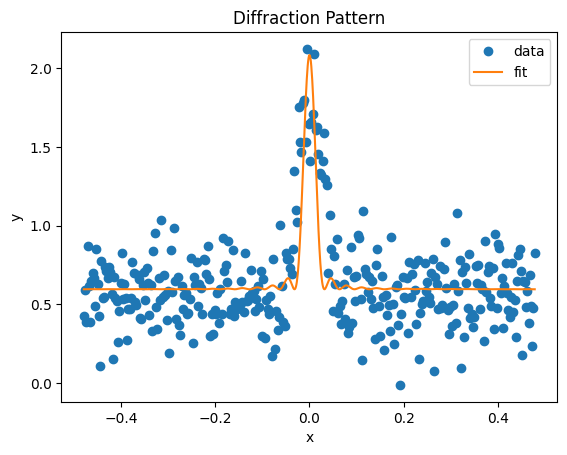

In [153]:
diffraction = pd.read_csv("diffraction.csv", delimiter=',')

c = 10
def FitFuncGivenC(x, a, b):
    return a + b*np.sinc(np.pi*c*x)**2

x = diffraction['x']
y = diffraction['y']

par, cov = curve_fit(FitFuncGivenC, x, y)

Xfit = np.linspace(np.min(x), np.max(x), 1000)
Yfit = FitFuncGivenC(Xfit, *par)

plt.title('Diffraction Pattern')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x, y, 'o', label='data')
plt.plot(Xfit, Yfit, label='fit')
plt.legend();
print(par)

There is a lot of noise outside of $x=0$, although the peak at $x=0$ is very clear.


(b) In the validation set approach, the dataset is randomly split into a training set and a testing set. Use `sample()` to create a variable `train` containing the indices of the data points in the training dataset. Then then refit the model above using only these data points.



In [154]:
from sklearn.model_selection import train_test_split

In [155]:
train, test = train_test_split(diffraction, test_size=0.2)

pargivenc, covgivenc = curve_fit(FitFuncGivenC, train['x'], train['y'])

(c) Compute the training and testing errors.



In [156]:
TrainingErrorGivenC = np.mean((train['y'] - FitFuncGivenC(train['x'], *pargivenc))**2)
TestingErrorGivenC = np.mean((test['y'] - FitFuncGivenC(test['x'], *pargivenc))**2)
print(f'Training error: {TrainingErrorGivenC}')
print(f'Testing error: {TestingErrorGivenC}')

Training error: 0.056979887883763417
Testing error: 0.054908398106257555


(d) While you think highly of your friend, you do not trust the value $c=10$. Fit a new model to the training data that optimizes $c$ in addition to $a$ and $b$ (you can set the initial value of $c$ to be 10). Compare the predictions of this fit and the previous fit by creating a line plot that shows  X vs. Y for both models as well as the experimental data. Does the fit look better? 



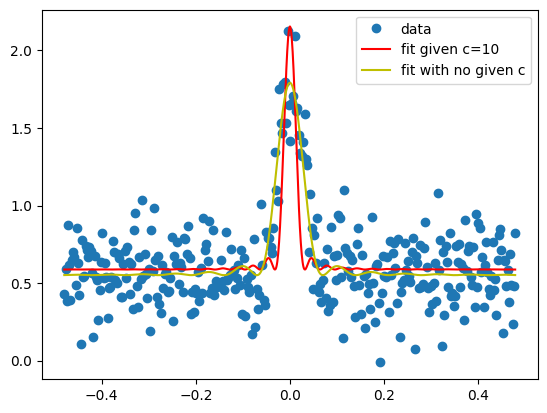

In [157]:
def FitFuncNoC(x, a, b, c):
    return a + b*np.sinc(np.pi*c*x)**2

parfitc, covfitc = curve_fit(FitFuncNoC, train['x'], train['y'])

YGivenC = FitFuncGivenC(Xfit, *pargivenc)
YNoC = FitFuncNoC(Xfit, *parfitc)

plt.plot(x, y, 'o', label='data')
plt.plot(Xfit, YGivenC, label='fit given c=10', c = 'r')
plt.plot(Xfit, YNoC, label='fit with no given c', c = 'y')
plt.legend();


It seems the fit with no given c, does not fit the data as well as the fit with c=10. The fit with c=10 seems to get the peak at $x=0$ better, but the fit with no given c seems to fit the data better outside of $x=0$.

(e) Evaluate the testing and training error. Are they bigger or smaller than the errors for the fit in (b)? What does this mean? 

In [158]:
TrainingErrorNoC = np.mean((train['y'] - FitFuncNoC(train['x'], *parfitc))**2)
TestingErrorNoC = np.mean((test['y'] - FitFuncNoC(test['x'], *parfitc))**2)
print(f'Training error with no given c: {TrainingErrorNoC}')
print(f'Testing error with no given c: {TestingErrorNoC}')

Training error with no given c: 0.037463674276191836
Testing error with no given c: 0.034571111739125235


They are both lower than in (b). This is due to the extra parameter $c$ that can be adjusted to fit the data (and noise) better.


## Problem 2

In this problem you will estimate the testing error using 10-fold cross-validation.

(a) The first step in 10-fold cross validation is to randomly assign each point in the dataset into one of the then 'folds'. Create a vector `folds` specifies which fold each datapoint belongs to (hint: There is an example of how to implement cross validation on page 273 in ISLR)





In [159]:
folds = np.random.randint(0, 10, len(diffraction))

(b) Fit a model (that has $c=10$) using all data except the data in the first partition, and estimate the testing error using only the data in the first partition


In [160]:
par_fold1, cov_fold1 = curve_fit(FitFuncGivenC, diffraction['x'][folds != 0], diffraction['y'][folds != 0])
testing_error_fold1 = np.mean((diffraction['y'][folds == 0] - FitFuncGivenC(diffraction['x'][folds == 0], *par_fold1))**2)
print(f'Testing error for fold 1: {testing_error_fold1}')

Testing error for fold 1: 0.05343267609271765


(c) To compute the cross-validated error, repeat the calculation above for all partitions and store the resulting errors in the array `cvMSEtest`. Then compute the mean of this array (hint: first create an empty array using `cvMSEtest=rep(NULL,K)`. Then loop over partitions using `for(i in 1:K) { ... }`).


In [161]:
cvMSEtest = []
for i in range(10):
    par_fold, cov_fold = curve_fit(FitFuncGivenC, diffraction['x'][folds != i], diffraction['y'][folds != i])
    testing_error_fold = np.mean((diffraction['y'][folds == i] - FitFuncGivenC(diffraction['x'][folds == i], *par_fold))**2)
    cvMSEtest.append(testing_error_fold)

(d) Compute the 10-fold cross-validation estimate of the testing error for the model that fits $c$ in addition to $a$ and $b$. Is it larger or smaller than the error model in (c)? 



In [162]:
cvMSEtestNoC = []
for i in range(10):
    par_fold, cov_fold = curve_fit(FitFuncNoC, diffraction['x'][folds != i], diffraction['y'][folds != i])
    testing_error_fold = np.mean((diffraction['y'][folds == i] - FitFuncNoC(diffraction['x'][folds == i], *par_fold))**2)
    cvMSEtestNoC.append(testing_error_fold)

print(f'Given c=10: {np.round(cvMSEtest,3)}')
print(f'No given c: {np.round(cvMSEtestNoC,3)}')

Given c=10: [0.053 0.045 0.042 0.059 0.056 0.055 0.079 0.08  0.033 0.079]
No given c: [0.028 0.035 0.043 0.041 0.054 0.026 0.037 0.036 0.032 0.052]


Again, the testing errors are lower with no given c (except in 1 case). This is due to the extra parameter $c$ that can be adjusted to fit the data better.

## Problem 3
In this problem you will use Bootstrap to estimate the standard error of your estimate of $c$. In part (a-b) you will implement Bootstrap manually and in part (c) you will use the library `boot`.

(a) First fit a model to a single bootstrap sample. As a first step, use `sample()` with `replace=T` to create an array of randomly sampled data point indices. Then fit a model using these data points. What is the estimated value of $c$? (hint: use the function `coef()`)

In [163]:
def BootStrap():
    datasample = diffraction.sample(len(diffraction), replace = True)
    parsample, covsample = curve_fit(FitFuncNoC, datasample['x'], datasample['y'])
    return parsample

BootStrap()[2]

4.528935018594572

(b) Repeat the calculation in (a) `R=100` times and store the parameter estimates in the array `bsParam`. What is the standard deviation of the values in `bsParam` and what does this correspond to? (hint: first create an empty array using `bsParams=rep(NULL,R)` and then loop over partitions using `for(i in 1:R) { ... }`)


In [164]:
bsParam = []
for _ in range(100):
    bsParam.append(BootStrap())
print(["a", "b", "c"])
print(np.std(bsParam, axis=0))

['a', 'b', 'c']
[0.00995107 0.0556484  0.1875487 ]


(c) Repeat the calculation but using the function `boot()` in the `boot` library. Did (b) and (c) give exactly the same answer? Why / why not? (hint: See section 5.3.4 in the book and wrap the code above in a function `boot.fn = function(data, index) {}`)


In [191]:
from scipy.stats import bootstrap

In [201]:
def BootStrapSciPy(datasample):
    parsample, covsample = curve_fit(FitFuncNoC, datasample['x'], datasample['y'])
    return parsample[2]
bootstrap(diffraction[:,:2], BootStrapSciPy, axis = 1)

InvalidIndexError: (slice(None, None, None), slice(None, 2, None))

I really cannot get it to work.

(d) Given your estimate $\hat c$ and the estimated standard error  $SE(\hat c)$, what is your conclusion about your friends' claim that $c=10$? Why?


In [208]:
print(f"c = {parfitc[2]:.2f} +/- {np.std(bsParam, axis=0)[2]:.2f}")

c = 4.55 +/- 0.19


My friends claim are many stardard deviations away from my estimate of $c$, and I therefore cannot confirm that $c=10$.

## Problem 4
In this problem you will use permutations to test if the detected diffraction pattern is statistically significant. Specifically, we will test the null hypothesis that $b=0$ (i.e. that the diffraction does not contribute to the signal), in which case the distribution of $Y$ is independent of $X$. 

(a) Starting with the data frame `df`, create a new data frame `dfTemp` by randomly permuting the output `df$y`. Fit a model with fixed $c=10$ to this permuted dataset. What is the value of $b$? (hint: use `sample()`)




In [166]:
def Permute():
    diffractionTemp = diffraction.copy()
    diffractionTemp['y'] = np.random.permutation(diffractionTemp['y'])

    parTemp, covTemp =  curve_fit(FitFuncGivenC, diffractionTemp['x'], diffractionTemp['y'])
    
    return parTemp
print(f'b: {Permute()[1]}')

b: -0.122542786905667


(b) Repeat the calculation in (a) `R=100` times and store the resulting $b$ estimates in the vector `permB`. Plot the values using a histogram. What is the mean and standard deviation of `permB`? (hint: use `hist()` to create a histogram)



Standard deviation of b: 0.11662853505180065, mean of b: -0.013375265316778726


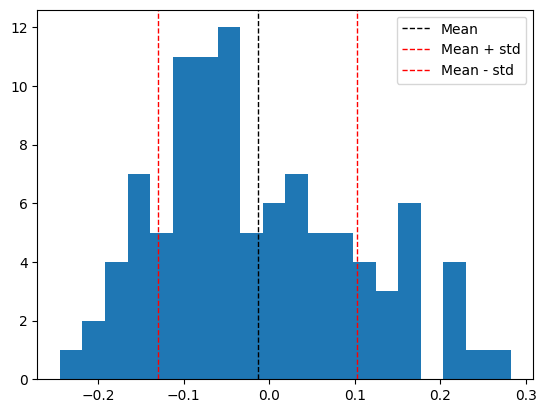

In [189]:
permB = []
for _ in range(100):
    permB.append(Permute()[1])

print(f'Standard deviation of b: {np.std(permB)}, mean of b: {np.mean(permB)}')
plt.hist(permB, bins=20)
plt.axvline(np.mean(permB), color='black', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(permB) + np.std(permB), color='r', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(permB) - np.std(permB), color='r', linestyle='dashed', linewidth=1)
plt.legend(['Mean', 'Mean + std', 'Mean - std'])
plt.show()

(c) What fraction of the $b$ estimates in `permB` are larger than the estimate in `fitIntro` (computed in the introduction)? What does this mean?

In [190]:
np.sum(permB > par[1])/len(permB)


0.0

None are bigger. This means that it is very unlikely that the diffraction pattern is random and we can reject the null hypothesis that $b=0$.